In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearnPipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# Les données

In [8]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df], ignore_index=True)
  # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    #df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df



In [4]:

def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('bureau.csv', nrows=num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows=num_rows)

    # Bureau balance: Perform aggregations
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau numeric features for aggregation
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }

    bureau_agg = bureau.groupby('SK_ID_CURR').agg(num_aggregations)
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Aggregate by current loan ID and merge numerical features for active and closed credits
    for credit_active_status in ['Active', 'Closed']:
        status_mask = bureau['CREDIT_ACTIVE'] == credit_active_status
        agg = bureau.loc[status_mask].groupby('SK_ID_CURR').agg(num_aggregations)
        agg.columns = pd.Index([f"{credit_active_status.upper()}_" + e[0] + "_" + e[1].upper() for e in agg.columns.tolist()])
        bureau_agg = bureau_agg.join(agg, how='left', on='SK_ID_CURR')

    del bureau
    gc.collect()

    return bureau_agg



In [5]:
# Preprocess previous_applications.csv
import pandas as pd
import numpy as np  # Assurez-vous d'importer numpy pour le traitement des valeurs spéciales
import gc  # Garbage collector interface

def previous_applications(num_rows=None):
    prev = pd.read_csv('previous_application.csv', nrows=num_rows)
    
    # Remplacement des valeurs spécifiques par NaN
    days_columns = ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
    for col in days_columns:
        prev[col].replace(365243, np.nan, inplace=True)
    
    # Ajout d'une nouvelle caractéristique : pourcentage du montant demandé sur le montant accordé
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Agrégations pour les caractéristiques numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }

    prev_agg = prev.groupby('SK_ID_CURR').agg(num_aggregations)
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Séparation et agrégation pour les demandes approuvées et refusées
    for status in ['Approved', 'Refused']:
        filtered_prev = prev[prev['NAME_CONTRACT_STATUS'] == status]
        agg = filtered_prev.groupby('SK_ID_CURR').agg(num_aggregations)
        agg.columns = pd.Index([status.upper() + '_' + e[0] + "_" + e[1].upper() for e in agg.columns.tolist()])
        prev_agg = prev_agg.join(agg, how='left', on='SK_ID_CURR')
    
    # Nettoyage de la mémoire
    del filtered_prev, agg, prev
    gc.collect()
    
    return prev_agg



In [14]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    #pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
     # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    #for cat in cat_cols:
        #aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [7]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    #ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
   # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    #for cat in cat_cols:
        #aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg



In [8]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('credit_card_balance.csv', nrows=num_rows)
    
    # Suppression de la colonne 'SK_ID_PREV'
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    
    # Aggrégation des colonnes numériques uniquement
    numeric_cols = cc.select_dtypes(include=['number']).columns
    agg_methods = ['min', 'max', 'mean', 'sum', 'var']
    cc_agg = cc.groupby('SK_ID_CURR')[numeric_cols].agg(agg_methods)
    
    # Renommage des colonnes pour la clarté
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Comptage du nombre de lignes de crédit par client
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    # Nettoyage de la mémoire
    del cc
    gc.collect()
    
    return cc_agg


remplaçer les blocs with timer() par des impressions directes, pour éviter l'erreur liée à l'utilisation de timer. 

In [9]:
from contextlib import contextmanager
import time

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0:.0f}s")

## Creation d'un seule dataset

In [15]:
def process_bureau_and_balance(df, num_rows):
    print("Processing bureau and bureau_balance")
    bureau = bureau_and_balance(num_rows)
    # nombre total de valeurs None avant le join
    total_none_pre_join = bureau.isnull().sum().sum()
    print(f"Total de valeurs None avant le join: {total_none_pre_join}")
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    #df = replace_infinities(df)  # Nettoyer les valeurs infinies
    #df = impute_missing_values(df)  # Imputation et nettoyage après le join
    # Calcul et affichage du nombre total de valeurs None après le join
    total_none_post_join = df.isnull().sum().sum()
    print(f"Total de valeurs None après le join: {total_none_post_join}")
    del bureau
    gc.collect()
    return df

def process_previous_applications(df, num_rows):
    print("Processing previous_applications")
    prev = previous_applications(num_rows)
    # nombre total de valeurs None avant le join
    total_none_pre_join = prev.isnull().sum().sum()
    print(f"Total de valeurs None avant le join: {total_none_pre_join}")
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    #df = replace_infinities(df)  # Nettoyer les valeurs infinies
    #df = impute_missing_values(df)  # Imputation et nettoyage après le join
    # Calcul et affichage du nombre total de valeurs None après le join
    total_none_post_join = df.isnull().sum().sum()
    print(f"Total de valeurs None après le join: {total_none_post_join}")
    del prev
    gc.collect()
    return df

def process_POS_CASH_balance(df, num_rows):
    print("Processing POS-CASH balance")
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    # nombre total de valeurs None avant le join
    total_none_pre_join = pos.isnull().sum().sum()
    print(f"Total de valeurs None avant le join: {total_none_pre_join}")
    df = df.join(pos, how='left', on='SK_ID_CURR')
    #df = replace_infinities(df)  # Nettoyer les valeurs infinies
    #df = impute_missing_values(df)  # Imputation et nettoyage après le join
    # Calcul et affichage du nombre total de valeurs None après le join
    total_none_post_join = df.isnull().sum().sum()
    print(f"Total de valeurs None après le join: {total_none_post_join}")
    del pos
    gc.collect()
    return df

def process_installments_payments(df, num_rows):
    print("Processing installments payments")
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    # nombre total de valeurs None avant le join
    total_none_pre_join = ins.isnull().sum().sum()
    print(f"Total de valeurs None avant le join: {total_none_pre_join}")
    df = df.join(ins, how='left', on='SK_ID_CURR')
    #df = replace_infinities(df)  # Nettoyer les valeurs infinies
    #df = impute_missing_values(df)  # Imputation et nettoyage après le join
    # Calcul et affichage du nombre total de valeurs None après le join
    total_none_post_join = df.isnull().sum().sum()
    print(f"Total de valeurs None après le join: {total_none_post_join}")
    del ins
    gc.collect()
    return df
    
def process_credit_card_balance(df, num_rows):
    print("Processing credit card balance")
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    # nombre total de valeurs None avant le join
    total_none_pre_join = cc.isnull().sum().sum()
    print(f"Total de valeurs None avant le join: {total_none_pre_join}")
    df = df.join(cc, how='left', on='SK_ID_CURR')
    #df = replace_infinities(df)  # Nettoyer les valeurs infinies
    #df = impute_missing_values(df)  # Imputation et nettoyage après le join
    # Calcul et affichage du nombre total de valeurs None après le join
    total_none_post_join = df.isnull().sum().sum()
    print(f"Total de valeurs None après le join: {total_none_post_join}")
    del cc
    gc.collect()
    return df

## Traitement des données

In [16]:
def process_data(debug=False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    
    df = process_bureau_and_balance(df, num_rows)
    df = process_previous_applications(df, num_rows)
    df = process_installments_payments(df, num_rows)
    df = process_credit_card_balance(df, num_rows)
    df = process_POS_CASH_balance(df, num_rows)

    return df

In [17]:
def main_process_data():
    df = process_data()
    return df

In [18]:
# Call main_process_data() to process the data
df = main_process_data()


Train samples: 307511, test samples: 48744


C:\Users\naoue\AppData\Local\Temp\ipykernel_25776\2731486051.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)


Processing bureau and bureau_balance
Total de valeurs None avant le join: 5611359
Bureau df shape: (305811, 81)
Total de valeurs None après le join: 20432181
Processing previous_applications


C:\Users\naoue\AppData\Local\Temp\ipykernel_25776\4169334312.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prev[col].replace(365243, np.nan, inplace=True)


Total de valeurs None avant le join: 7608405
Previous applications df shape: (338857, 90)
Total de valeurs None après le join: 29606393
Processing installments payments
Installments payments df shape: (339587, 26)
Total de valeurs None avant le join: 2054
Total de valeurs None après le join: 30041815
Processing credit card balance
Credit card balance df shape: (103558, 106)
Total de valeurs None avant le join: 891706
Total de valeurs None après le join: 57718979
Processing POS-CASH balance
Pos-cash balance df shape: (337252, 8)
Total de valeurs None avant le join: 0
Total de valeurs None après le join: 57871003


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Columns: 438 entries, SK_ID_CURR to POS_COUNT
dtypes: float64(383), int64(42), object(13)
memory usage: 1.2+ GB


### Nettoyer les colonnes et transformer les infinities

In [20]:
import re
# fonction pour nettoyer les noms de caractéristiques
def clean_feature_names(df):
    # Remplacer les caractères spéciaux par des underscores ou tout autre caractère de votre choix
    clean_names = {col: re.sub(r'[^\w\s]', '_', col) for col in df.columns}
    return df.rename(columns=clean_names)

# Nettoyer les noms de caractéristiques de df
df_propre = clean_feature_names(df)


In [21]:
def replace_infinities(df):
    # Remplacer les +inf/-inf par NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [22]:
# Appliquer replace_infinities
df_propre = replace_infinities(df_propre)

# Garder  30 % du dataframe

In [23]:

def stratified_sample_df(df, col, frac):
    """
    Retourne un échantillon stratifié du DataFrame df basé sur la colonne col.
    
    :param df: DataFrame à échantillonner.
    :param col: Colonne utilisée pour le stratified sampling.
    :param frac: Fraction de chaque classe à retourner.
    """
    # Créer un DataFrame vide pour stocker l'échantillon stratifié
    stratified_sample = pd.DataFrame()

    # Obtenir les proportions uniques et le nombre d'occurrences pour chaque classe
    class_counts = df[col].value_counts(normalize=True) * frac
    
    # Pour chaque classe unique, échantillonner des lignes de manière proportionnelle
    for class_value in df[col].unique():
        class_sample = df[df[col] == class_value].sample(frac=frac)
        stratified_sample = pd.concat([stratified_sample, class_sample], axis=0)
    
    return stratified_sample


sampled_df = stratified_sample_df(df_propre, 'TARGET', 0.3)


In [24]:
# Afficher les premières lignes du DataFrame échantillonné
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92253 entries, 139938 to 46069
Columns: 438 entries, SK_ID_CURR to POS_COUNT
dtypes: float64(383), int64(42), object(13)
memory usage: 309.0+ MB


In [25]:
sampled_df.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_SK_DPD_DEF_VAR,CC_COUNT,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_COUNT
139938,262265,1.0,Cash loans,0,1,0,0,225000.0,667422.0,43155.0,...,NaN,NaN,-1.0,-3.818182,11.0,0.0,0.000000,0.0,0.000000,11.0
96256,211750,1.0,Revolving loans,0,1,0,0,189000.0,270000.0,13500.0,...,NaN,NaN,-1.0,-7.333333,12.0,0.0,0.000000,0.0,0.000000,12.0
288418,434125,1.0,Cash loans,0,0,0,0,112500.0,254700.0,14751.0,...,NaN,NaN,-5.0,-17.000000,25.0,10.0,0.400000,10.0,0.400000,25.0
174404,302110,1.0,Cash loans,1,1,0,1,180000.0,382500.0,18733.5,...,0.000000,20.0,-7.0,-8.000000,3.0,0.0,0.000000,0.0,0.000000,3.0
283799,428667,1.0,Cash loans,1,0,0,0,180000.0,801963.0,31932.0,...,NaN,NaN,-2.0,-25.046729,107.0,15.0,0.140187,15.0,0.140187,107.0
114878,233208,1.0,Cash loans,1,0,0,0,180000.0,697500.0,66357.0,...,0.020829,95.0,-22.0,-24.000000,5.0,0.0,0.000000,0.0,0.000000,5.0
147587,271127,1.0,Cash loans,1,0,1,0,261000.0,1006920.0,51543.0,...,0.000000,7.0,-2.0,-21.076923,26.0,0.0,0.000000,0.0,0.000000,26.0
135076,256659,1.0,Cash loans,1,0,1,3,112500.0,808650.0,26086.5,...,NaN,NaN,-8.0,-43.090909,44.0,14.0,0.590909,14.0,0.590909,44.0
155986,280819,1.0,Cash loans,0,0,0,1,63000.0,715500.0,20920.5,...,NaN,NaN,-8.0,-17.000000,19.0,0.0,0.000000,0.0,0.000000,19.0
182472,311489,1.0,Revolving loans,1,0,0,1,99000.0,337500.0,16875.0,...,NaN,NaN,-2.0,-26.936709,79.0,0.0,0.000000,0.0,0.000000,79.0


In [26]:
sampled_df.TARGET.isnull().sum()

0

### Afficher la distribution de la colonne target

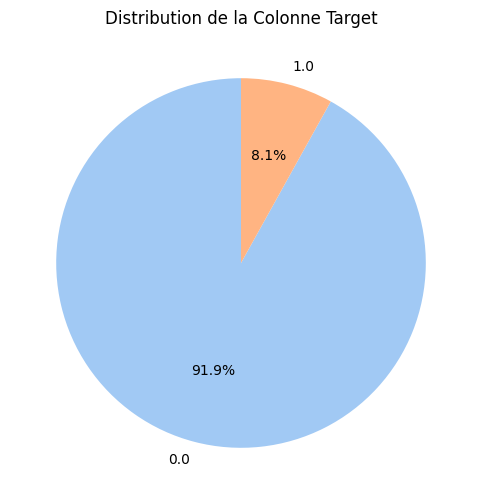

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculer les fréquences des valeurs de la colonne target
target_counts = sampled_df['TARGET'].value_counts()

# Créer un pie chart
plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution de la Colonne Target')
plt.show()

### Enregister les données traitées avec target

In [ ]:
## supprimer la target avant (données utiliser dans le dashboard)

In [24]:
data_for_dashboard = sampled_df.drop('TARGET', axis = 1)

In [25]:
data_for_dashboard.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_SK_DPD_DEF_VAR,CC_COUNT,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_COUNT
141791,264403,Cash loans,1,0,1,0,112500.0,325804.5,15673.5,325804.5,...,NaN,NaN,-26.0,-32.000000,13.0,0.0,0.000000,0.0,0.000000,13.0
201989,334144,Cash loans,0,1,0,1,157500.0,816660.0,31774.5,585000.0,...,NaN,NaN,-1.0,-14.736842,19.0,0.0,0.000000,0.0,0.000000,19.0
189781,320048,Cash loans,1,0,1,0,90000.0,290088.0,8608.5,229500.0,...,NaN,NaN,-2.0,-36.760000,25.0,0.0,0.000000,0.0,0.000000,25.0
51683,159848,Cash loans,0,1,1,2,121500.0,284400.0,22599.0,225000.0,...,NaN,NaN,-3.0,-23.676471,34.0,6.0,0.323529,6.0,0.323529,34.0
43920,150860,Cash loans,0,1,0,2,135000.0,601470.0,28935.0,450000.0,...,0.0,27.0,-26.0,-28.500000,6.0,0.0,0.000000,0.0,0.000000,6.0


In [26]:
data_for_dashboard.to_csv('données_pour_model.csv', index= False)

In [27]:
print(sampled_df.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'CC_SK_DPD_DEF_VAR', 'CC_COUNT', 'POS_MONTHS_BALANCE_MAX',
       'POS_MONTHS_BALANCE_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'POS_SK_DPD_MAX',
       'POS_SK_DPD_MEAN', 'POS_SK_DPD_DEF_MAX', 'POS_SK_DPD_DEF_MEAN',
       'POS_COUNT'],
      dtype='object', length=438)


### Enregister les données traitées sans target

In [30]:
df['TARGET'].isnull().sum()

48744

In [27]:
# Filtrer le DataFrame
df_sans_target = df[df['TARGET'].isnull()]
df_sans_target.shape

(48744, 438)

In [28]:
df_sans_target.to_csv('données_sans_target.csv', index =False )

In [29]:
df_sans_target.shape

(48744, 438)

# Score metier

P c'est 1 il ne rembourse pas   
N c'est 0  il rembourse

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  make_scorer

In [29]:
def fonction_cout_metier_version_1(y_true, y_proba):
    liste_loss = []
    for th in np.arange(0, 1, 0.1):
        y_pred = (y_proba > th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cout = fp + (10 * fn)  # le coût d'un FN est 10 fois celui d'un FP
        liste_loss.append(cout)
    
    min_loss = min(liste_loss)
    return min_loss


In [30]:
metier_scorer_one = make_scorer(fonction_cout_metier_version_1, greater_is_better=False, needs_proba=True)


C:\Users\naoue\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


## 1. LGBMClassifier  modele

In [31]:
def clean_feature_names(df):
    df.columns = ["".join(c if c.isalnum() else "_" for c in str(col)) for col in df.columns]
    return df

# Appliquez cette fonction à votre DataFrame avant la division en X_train, y_train, etc.
sampled_df = clean_feature_names(sampled_df)

In [32]:
print(sampled_df.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'CC_SK_DPD_DEF_VAR', 'CC_COUNT', 'POS_MONTHS_BALANCE_MAX',
       'POS_MONTHS_BALANCE_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'POS_SK_DPD_MAX',
       'POS_SK_DPD_MEAN', 'POS_SK_DPD_DEF_MAX', 'POS_SK_DPD_DEF_MEAN',
       'POS_COUNT'],
      dtype='object', length=438)


### feature importance

In [33]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


### Grid search & Smote

SMOTE est appliqué uniquement sur les données d'entraînement à chaque pli de la validation croisée, ce qui empêche la fuite de données et assure que les données suréchantillonnées ne contaminent pas l'ensemble de validation.

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# Définir le scorer personnalisé
metier_scorer = make_scorer(roc_auc_score, needs_proba=True)

def kfold_lightgbm_grid_search(df, num_folds, stratified=False, debug=False):
    # Séparation initiale en ensembles d'entraînement et de test
    train_df, test_df = train_test_split(df, test_size=0.20, stratify=df['TARGET'], random_state=42)
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
    # Déterminer les features numériques et catégorielles
    numerical_feats = [f for f in train_df.columns if train_df[f].dtype in ['int64', 'float64'] and f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
    categorical_feats = [f for f in train_df.columns if train_df[f].dtype == 'object']
    
    
    
    handle_collinearity = True 

    # Création du ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numerical_feats),
            ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
             ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first' if handle_collinearity else None))
        ]), categorical_feats) 
        ]
    )

    # Création du pipeline avec ColumnTransformer
    pipeline = make_pipeline_imb(
        preprocessor,
        SMOTE(random_state=42),
        LGBMClassifier(nthread=4, silent=-1, verbose=-1)
    )
    
    # Paramètres pour GridSearchCV (ajustez selon vos besoins)
    param_grid = {
        'lgbmclassifier__n_estimators': [1000, 5000],
        'lgbmclassifier__learning_rate': [0.01, 0.02],
        'lgbmclassifier__max_depth': [7, 8]
    }
    
    # Choix du type de KFold
    # Choix du type de KFold
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    
    # Configuration et exécution du GridSearchCV
    gsearch = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=metier_scorer, n_jobs=1, cv=folds, verbose=3, error_score='raise')

    
     # Sélection des caractéristiques pour l'entraînement
    X_train = train_df[numerical_feats + categorical_feats]
    y_train = train_df['TARGET']
    
    
    try:
        gsearch.fit(X_train, y_train)
        print("Meilleur score AUC: %s" % gsearch.best_score_)
        print("Meilleurs paramètres: %s" % gsearch.best_params_)
        
           # Prédiction sur l'ensemble de test avec le meilleur modèle trouvé
        test_df['TARGET'] = gsearch.predict_proba(test_df[numerical_feats + categorical_feats])[:, 1]
        if not debug:
            test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_grid_search.csv', index=False)

    except Exception as e:
        print("Une erreur s'est produite pendant la recherche par grille ou la prédiction :", e)
        return None
    
    return gsearch.best_estimator_


In [37]:
best_model = kfold_lightgbm_grid_search(sampled_df, num_folds=3, stratified=True, debug=False)


Starting LightGBM. Train shape: (73802, 438), test shape: (18451, 438)
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=1000;, score=0.768 total time= 1.1min
[CV 2/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=1000;, score=0.758 total time=  51.5s


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=1000;, score=0.769 total time=  52.8s


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=5000;, score=0.759 total time= 3.8min
[CV 2/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=5000;, score=0.749 total time= 3.7min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=5000;, score=0.759 total time= 3.7min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=1000;, score=0.770 total time= 1.2min
[CV 2/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=1000;, score=0.759 total time= 1.2min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=1000;, score=0.770 total time= 1.2min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=5000;, score=0.760 total time= 3.8min
[CV 2/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=5000;, score=0.748 total time= 4.3min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmclassifier__learning_rate=0.01, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=5000;, score=0.759 total time= 4.3min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=1000;, score=0.769 total time= 1.1min
[CV 2/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=1000;, score=0.757 total time=  58.1s


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=1000;, score=0.769 total time= 1.0min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=5000;, score=0.748 total time= 3.9min
[CV 2/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=5000;, score=0.738 total time= 3.4min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=7, lgbmclassifier__n_estimators=5000;, score=0.742 total time= 3.8min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=1000;, score=0.770 total time=  58.6s
[CV 2/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=1000;, score=0.757 total time=  58.6s


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=1000;, score=0.770 total time=  58.3s


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 1/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=5000;, score=0.749 total time= 4.0min
[CV 2/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=5000;, score=0.734 total time= 3.5min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\my_env\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 3/3] END lgbmclassifier__learning_rate=0.02, lgbmclassifier__max_depth=8, lgbmclassifier__n_estimators=5000;, score=0.744 total time= 3.6min
Meilleur score AUC: 0.7662757555887704
Meilleurs paramètres: {'lgbmclassifier__learning_rate': 0.01, 'lgbmclassifier__max_depth': 8, 'lgbmclassifier__n_estimators': 1000}


## Le meilleure modele

### Entrainer le meilleures modele

In [38]:


# Afficher les meilleurs paramètres
print("Les meilleurs paramètres sont :", best_model)

Les meilleurs paramètres sont : Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
            

In [39]:
# Récupération de l'objet LGBMClassifier depuis la pipeline
lgbm_classifier = best_model.named_steps['lgbmclassifier']
lgbm_classifier

LGBMClassifier(learning_rate=0.01, max_depth=8, n_estimators=1000, nthread=4,
               silent=-1, verbose=-1)

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearnPipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

def train_best_model(df, best_model):
    # Supposons que vous ayez déjà défini numerical_feats et categorical_feats
    numerical_feats = [f for f in df.columns if df[f].dtype in ['int64', 'float64'] and f not in ['TARGET']]
    categorical_feats = [f for f in df.columns if df[f].dtype == 'object']

    # Définir le ColumnTransformer ici
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numerical_feats),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
            ]), categorical_feats)
        ]
    )

    # Division en ensembles d'entraînement et de validation
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Récupération des paramètres depuis best_pipeline (hypothétiquement fournie)
    lgbm_classifier = best_model.named_steps['lgbmclassifier']
    lgbm_params = {
        'n_estimators': lgbm_classifier.n_estimators,
        'learning_rate': lgbm_classifier.learning_rate,
        'max_depth': lgbm_classifier.max_depth,
        
    }

        # Création de la pipeline avec les meilleurs paramètres et le ColumnTransformer
    pipeline = imblearnPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LGBMClassifier(
            n_estimators=lgbm_params['n_estimators'],
            learning_rate=lgbm_params['learning_rate'],
            max_depth=lgbm_params['max_depth'],
            nthread=4, silent=-1, verbose=-1
        ))
    ])


    # Entraînement de la pipeline sur l'ensemble d'entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions sur l'ensemble de validation
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    y_pred = pipeline.predict(X_val)

    # Calcul de la fonction de coût métier, de l'AUC et de l'accuracy
    cout_metier = fonction_cout_metier_version_1(y_val, y_pred_proba)
    auc_score = roc_auc_score(y_val, y_pred_proba)
    accuracy = accuracy_score(y_val, y_pred)

    # Affichage des scores
    print(f"Coût métier: {cout_metier}")
    print(f"AUC: {auc_score}")
    print(f"Accuracy: {accuracy}")


    return pipeline, X_train, X_val, y_train, y_val 



In [41]:
pipeline, X_train, X_val, y_train, y_val  = train_best_model(sampled_df)

C:\Users\naoue\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\naoue\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\naoue\Anaconda3\envs\third_env\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\naoue\Anaconda3\envs\third_env\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\naoue\Anaconda3\envs\third_env\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.Cre

Coût métier: 9608
AUC: 0.7586504214761935
Accuracy: 0.9192455693458349


In [42]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['SK_ID_CURR', 'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'OWN_CAR_A...
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LGBMClassifier(learning_rate=0.01, max_depth=8,
                                n_estimators=1000, nthread=4, silent=-1,
                                verbose=-1))])

### feature_importances

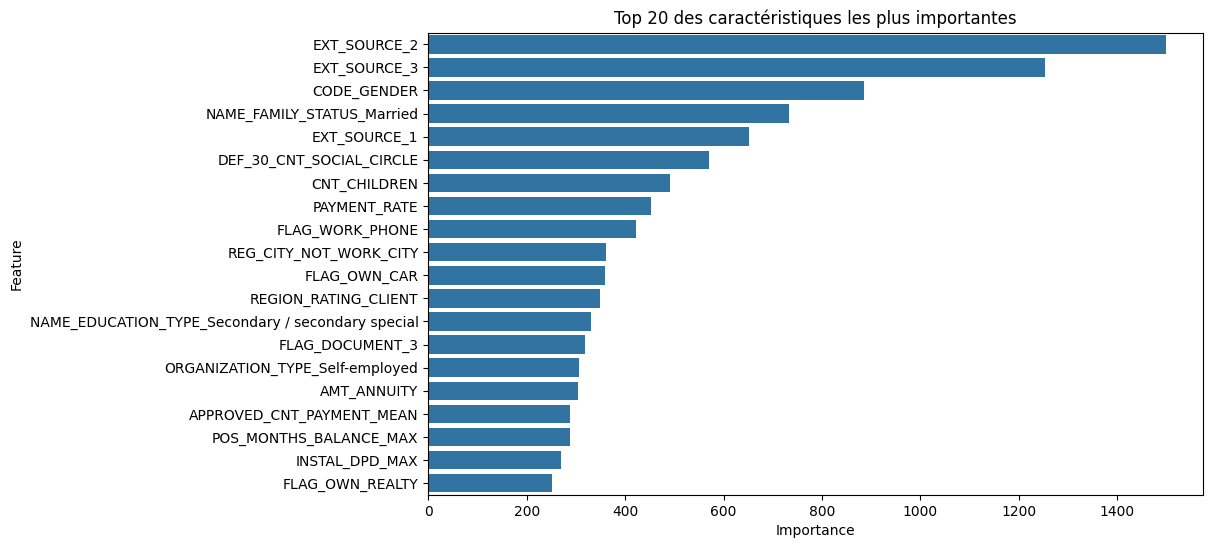

In [50]:
# Extraire les importances des caractéristiques
feature_importances = pipeline.named_steps['classifier'].feature_importances_

#  définir numerical_feats et categorical_feats
numerical_feats = [f for f in sampled_df.columns if sampled_df[f].dtype in ['int64', 'float64'] and f not in ['TARGET']]
categorical_feats = [f for f in sampled_df.columns if sampled_df[f].dtype == 'object']
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(input_features=categorical_feats)
feature_names = np.concatenate([numerical_feats, feature_names])

# Assurez-vous que la longueur des noms de caractéristiques correspond à celle des importances
assert len(feature_names) == len(feature_importances), "La longueur des noms de caractéristiques ne correspond pas à celle des importances"

# Créer un DataFrame pour faciliter la visualisation
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(20))
plt.title('Top 20 des caractéristiques les plus importantes')
plt.show()

## Feature importance avec Shap

 Résumé:
- Les **importances globales** aident à comprendre quelles caractéristiques jouent un rôle majeur dans les prédictions du modèle sur l'ensemble du jeu de données. Cela donne une idée générale de l'importance relative des caractéristiques.
  
- Les **importances locales** fournissent des détails sur la façon dont les différentes caractéristiques influencent la prédiction pour une instance spécifique. Cela est utile pour l'interprétation des décisions du modèle au niveau individuel, permettant de voir pourquoi le modèle a fait une certaine prédiction pour un seul échantillon.

En combinant ces deux types d'analyses, vous pouvez obtenir une compréhension complète à la fois de l'importance générale des caractérilees dans votre modèle et de la manière dont ces caractéristiques influencent les prédictions sur des observations spécifiques.

In [67]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [135]:
# Transformer les données d'entraînement (comme indiqué dans la réponse précédente)
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)

# Obtenir les noms des caractéristiques transformées
feature_names_transformed = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Créer l'explainer SHAP (assurez-vous que cela correspond à votre modèle)
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])

# Calculer les valeurs SHAP pour les données transformées
shap_values = explainer.shap_values(X_train_transformed)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [68]:
# Transformer les données d'entraînement (comme indiqué dans la réponse précédente)
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)

# Obtenir les noms des caractéristiques transformées
feature_names_transformed = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Créer l'explainer SHAP (assurez-vous que cela correspond à votre modèle)
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])

# Calculer les valeurs SHAP pour les données transformées
shap_values = explainer.shap_values(X_train_transformed)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


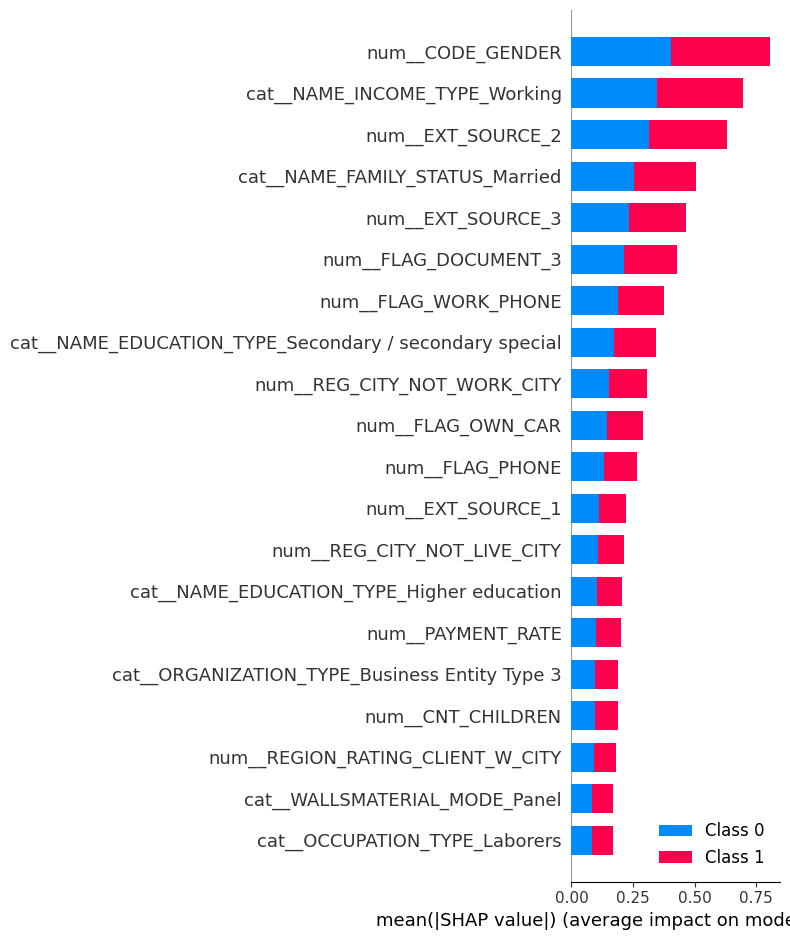

In [137]:
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names_transformed)


Impact des Caractéristiques:  
**CODE_GENDER**: 
La caractéristique la plus en haut a le plus grand impact sur la prédiction. Si la barre pour cette caractéristique est majoritairement rouge, cela suggère que selon les valeurs de cette caractéristique, les prédictions sont plus susceptibles d'être en faveur de la classe 1.  
**EXT_SOURCE_2, EXT_SOURCE_3**:
Ces caractéristiques semblent avoir également un impact significatif sur les prédictions, avec des contributions dans les deux directions selon leur valeur spécifique.

In [69]:
# Initialise la bibliothèque JavaScript pour SHAP
shap.initjs()

In [139]:
# Utiliser le Premier Ensemble de Valeurs SHAP (Généralement pour la Classe Négative) (classification binaire)

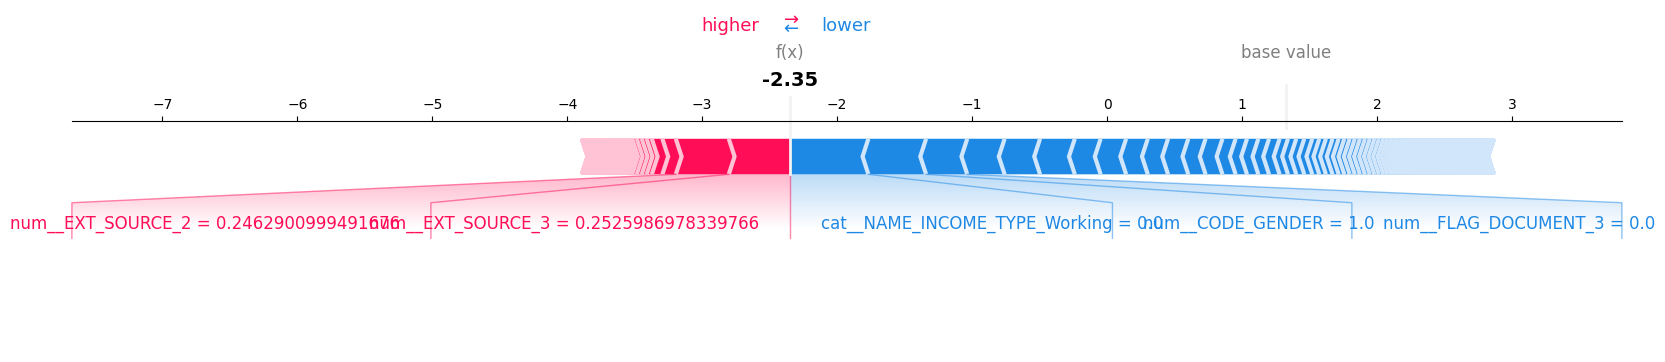

In [70]:
# Calculer les valeurs SHAP pour une instance spécifique
instance_index = 0  # la première instance
instance_shap_values = shap_values[1][instance_index]
instance_data = X_train_transformed[instance_index]

# Afficher le graphique de force plot avec les noms des caractéristiques
shap.force_plot(explainer.expected_value[1], instance_shap_values, instance_data, feature_names=feature_names_transformed, matplotlib=True)

# Afficher le graphique de force plot
plt.show()

## Enregister mon modele light gbm

In [52]:
pipeline.named_steps['classifier']

LGBMClassifier(learning_rate=0.01, max_depth=8, n_estimators=1000, nthread=4,
               silent=-1, verbose=-1)

In [53]:
import pickle

# Supposons que best_model_pipeline est votre pipeline/model que vous souhaitez enregistrer
model_to_save = pipeline

# Spécifiez le chemin et le nom du fichier où vous souhaitez enregistrer le modèle
filename =  'mlruns\models\lightgbm_model.pkl'

# Enregistrez le modèle dans le fichier
with open(filename, 'wb') as file:
    pickle.dump(model_to_save, file)

print(f"Modèle enregistré avec succès sous {filename}")


Modèle enregistré avec succès sous mlruns\models\lightgbm_model.pkl


### Sauvegarder les transformateur

In [54]:
from joblib import dump
preprocessor = pipeline.named_steps['preprocessor']

In [55]:
dump(preprocessor, 'preprocessor.joblib')

['preprocessor.joblib']

### sauvegarde la pipeline

In [56]:
dump(pipeline, 'mlruns\models\mon_pipeline_complet.joblib')

['mlruns\\models\\mon_pipeline_complet.joblib']

## MLFLOW

In [34]:
import mlflow
from joblib import load

# loadle modele
best_model_pipeline  = load('models/mon_pipeline_complet.joblib')


C:\Users\naoue\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\naoue\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\naoue\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1

In [35]:
model_lgbm = best_model_pipeline.named_steps['classifier']

In [50]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib

# Configuration de l'URI de suivi MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

def log_metrics_with_mlflow(pipeline, X_val, y_val, run_name="Model light GBM Evaluation"):
    with mlflow.start_run(run_name=run_name):
        # Prédictions sur l'ensemble de validation
        y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
        y_pred = pipeline.predict(X_val)
        

        # Calculer la précision, le rappel, et l'AUC
        # Évaluation du modèle
        Lgbm_cout_metier = fonction_cout_metier_version_1(y_val, y_pred_proba)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred_proba)

        # Calculer et tracer la courbe ROC
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig("roc_curve.png")

        # Enregistrer les métriques dans MLflow
        mlflow.log_metric('Lgbm Coût métier',Lgbm_cout_metier)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("auc", auc)

        # Enregistrer la courbe ROC comme un artefact
        mlflow.log_artifact("roc_curve.png")

        # Enregistrer le modèle
        mlflow.sklearn.log_model(pipeline, "model")



c:\Users\naoue\Anaconda3\envs\third_env\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\naoue\Anaconda3\envs\third_env\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


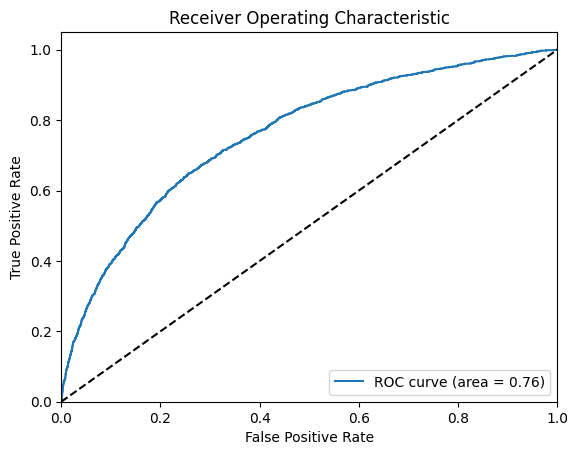

In [51]:
mlflow = log_metrics_with_mlflow(pipeline, X_val, y_val)

La courbe ROC du modèle montre que le modèle a une bonne capacité de discrimination. L'AUC de 0.77 est considérablement meilleur qu'un modèle aléatoir

Étape 1: mlflow ui( dans la CMD) dans le chemin du dossier projet 7

Cette commande démarre le serveur web de l'interface utilisateur MLflow localemen t.

Étape 2 : Accéder à l'Interface Utilisateur de MLflow
ir vle otre navigateur web.

Accédez à l'URL de MLflateur.

## 2. DummyClassifier

une approche naïve/simple.

In [61]:
from sklearn.dummy import DummyClassifier


In [62]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train, y_train)


DummyClassifier(random_state=42, strategy='stratified')

In [63]:
y_dummy_pred_proba = dummy_clf.predict_proba(X_val)[:, 1] 
y_dummy_pred = dummy_clf.predict(X_val)

# Évaluation
dummy_cout_metier = fonction_cout_metier_version_1(y_val, y_dummy_pred_proba)  
dummy_auc_score = roc_auc_score(y_val, y_dummy_pred_proba)  
dummy_accuracy = accuracy_score(y_val, y_dummy_pred)

# Affichage des scores pour le DummyClassifier
print(f"Dummy Coût métier: {dummy_cout_metier}")
print(f"Dummy AUC: {dummy_auc_score}")
print(f"Dummy Accuracy: {dummy_accuracy}")


Dummy Coût métier: 15152
Dummy AUC: 0.4971381641816263
Dummy Accuracy: 0.8509565877188229


### ml flow

In [51]:
import mlflow


In [64]:
def log_dummy_model(X_train, y_train, X_val, y_val):
    with mlflow.start_run(run_name="Dummy Classifier Evaluation"):
             # Création et entraînement du modèle
        dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
        dummy_clf.fit(X_train, y_train)
        
        # Prédictions sur l'ensemble de validation
        y_dummy_pred_proba = dummy_clf.predict_proba(X_val)[:, 1]
        y_dummy_pred = dummy_clf.predict(X_val)
        
        # Évaluation du modèle
        dummy_cout_metier = fonction_cout_metier_version_1(y_val, y_dummy_pred_proba)  # Assurez-vous que cette fonction est définie
        dummy_auc_score = roc_auc_score(y_val, y_dummy_pred_proba)
        dummy_accuracy = accuracy_score(y_val, y_dummy_pred)
        precision = precision_score(y_val, y_dummy_pred)
        recall = recall_score(y_val, y_dummy_pred)

        # Affichage des scores
        print(f"Dummy Coût métier: {dummy_cout_metier}")
        print(f"Dummy AUC: {dummy_auc_score}")
        print(f"Dummy Accuracy: {dummy_accuracy}")

        # Tracé de la courbe ROC
        fpr, tpr, thresholds = roc_curve(y_val, y_dummy_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % dummy_auc_score)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic - Dummy')
        plt.legend(loc="lower right")
        plt.savefig("dummy_roc_curve.png")

        # Enregistrement des métriques et de la courbe ROC dans MLflow
        mlflow.log_metric("cost_metier", dummy_cout_metier)
        mlflow.log_metric("auc", dummy_auc_score)
        mlflow.log_metric("accuracy", dummy_accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_artifact("dummy_roc_curve.png")

        # Enregistrement du modèle
        mlflow.sklearn.log_model(dummy_clf, "dummy_model")

In [ ]:
experiment_name = "DummyClassifier Evaluation"
experiment_id = mlflow.create_experiment(experiment_name)

# Définir l'expérience active pour enregistrer les runs dans cette expérience
mlflow.set_experiment(experiment_name)

Dummy Coût métier: 15152
Dummy AUC: 0.4971381641816263
Dummy Accuracy: 0.8509565877188229


c:\Users\naoue\Anaconda3\envs\third_env\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\naoue\Anaconda3\envs\third_env\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


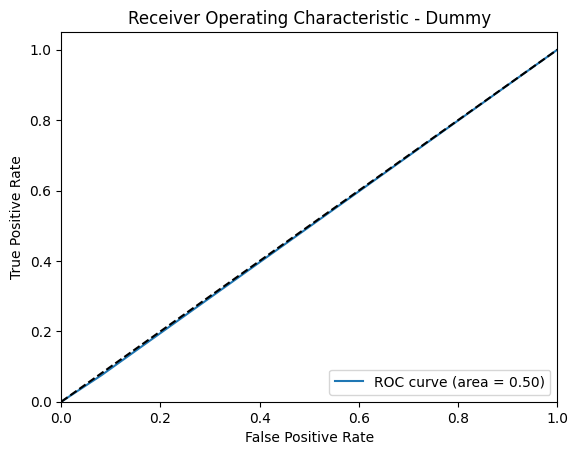

In [65]:
log_dummy_model(X_train, y_train, X_val, y_val)


In [101]:
# Démarrer un nouveau run MLflow
with mlflow.start_run(run_name="DummyClassifier Evaluation"):
    # Log des paramètres du modèle (s'il y en a)
    mlflow.log_param("strategy", "most_frequent")
    
    # Enregistrer les métriques de performance
    mlflow.log_metric("cost_metric", dummy_cout_metier)
    mlflow.log_metric("auc_score", dummy_auc_score)
    mlflow.log_metric("accuracy", dummy_accuracy)
    
    # Enregistrer le modèle DummyClassifier (facultatif)
    mlflow.sklearn.log_model(dummy_clf, "dummy_classifier")

## 3. Random forest classifier

### Grid search

In [147]:
from sklearn.ensemble import RandomForestClassifier

def kfold_random_forest_grid_search(df, num_folds, stratified=False, debug=False):
    # Supposons que vous ayez déjà défini numerical_feats et categorical_feats
    numerical_feats = [f for f in df.columns if df[f].dtype in ['int64', 'float64'] and f not in ['TARGET']]
    categorical_feats = [f for f in df.columns if df[f].dtype == 'object']

    # Définir le ColumnTransformer ici
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numerical_feats),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
            ]), categorical_feats)
        ]
    )

    # Division en ensembles d'entraînement et de validation
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    
    # Création du pipeline avec ColumnTransformer et RandomForestClassifier
    pipeline = make_pipeline_imb(
        preprocessor,
        SMOTE(random_state=42),
        RandomForestClassifier(n_jobs=-1, verbose=1)
    )
    
    # Paramètres pour GridSearchCV adaptés pour RandomForestClassifier
    param_grid = {
        'randomforestclassifier__n_estimators': [100, 200],
        'randomforestclassifier__max_depth': [None, 10, 20],
        'randomforestclassifier__min_samples_split': [2, 5],
        'randomforestclassifier__min_samples_leaf': [1, 2]
    }
    
    # Choix du type de KFold
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    
    # Configuration et exécution du GridSearchCV
    gsearch = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=metier_scorer, n_jobs=-1, cv=folds, verbose=3, error_score='raise')

    # Sélection des caractéristiques pour l'entraînement
    X_train = df[numerical_feats + categorical_feats]
    y_train = df['TARGET']
    
    try:
        gsearch.fit(X_train, y_train)
        print("Meilleur score AUC: %s" % gsearch.best_score_)
        print("Meilleurs paramètres: %s" % gsearch.best_params_)
        
        # Prédiction sur l'ensemble de test avec le meilleur modèle trouvé
        test_df['TARGET'] = gsearch.predict_proba(test_df[numerical_feats + categorical_feats])[:, 1]
        if not debug:
            test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_grid_search_rf.csv', index=False)
    except Exception as e:
        print("Une erreur s'est produite pendant la recherche par grille ou la prédiction :", e)
        return None
    
    return gsearch.best_estimator_


In [148]:
best_estimator = kfold_random_forest_grid_search(sampled_df, num_folds = 3, stratified=True, debug=False)

Starting RandomForest. Train shape: (73802, 438), test shape: (18451, 438)
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.0min finished


Meilleur score AUC: 0.7149421659910719
Meilleurs paramètres: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200}


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished


In [149]:
best_estimator

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'OWN_CAR_AGE', 'FLA...
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, min_samples_split=5,
                                        n_estimators=200, n_jobs=-1,
                                        verbose=1))])

In [183]:

# Extraire le meilleur modèle RandomForestClassifier de la pipeline
best_rf_model = best_estimator.named_steps['randomforestclassifier']

# Obtenir les paramètres du meilleur modèle
best_rf_params = best_rf_model.get_params()

print("Paramètres optimisés du RandomForestClassifier:", best_rf_params)

Paramètres optimisés du RandomForestClassifier: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 1, 'warm_start': False}


In [ ]:
Paramètres_RandomForestClassifier=
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 1, 'warm_start': False}

## Le meilleure modele

### Entrainer le meilleures modele

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imblearnPipeline
from sklearn.pipeline import Pipeline as sklearnPipeline
from imblearn.over_sampling import SMOTE
import pandas as pd

def train_best_rfc_model(df):
    """
    Entraîne un modèle RandomForestClassifier avec un prétraitement spécifique,
    en utilisant le meilleur modèle fourni comme base pour les hyperparamètres.

    Parameters:
    df (pandas.DataFrame): DataFrame contenant les données d'entraînement et la cible.
    best_model (sklearn estimator): Meilleur modèle RandomForest obtenu après recherche d'hyperparamètres.

    Returns:
    tuple: Contenant le pipeline entraîné, les ensembles de données d'entraînement et de validation,
           et le DataFrame des importances des caractéristiques.
    """
        
    if 'TARGET' not in df.columns:
        raise ValueError("La colonne 'TARGET' est absente du DataFrame.")

    # Définition des caractéristiques numériques et catégorielles
    numerical_feats = [f for f in df.columns if df[f].dtype in ['int64', 'float64'] and f not in ['TARGET']]
    categorical_feats = [f for f in df.columns if df[f].dtype == 'object']

    # Préprocesseur pour les caractéristiques numériques et catégorielles
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numerical_feats),
            ('cat', sklearnPipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
            ]), categorical_feats)
        ]
    )

    # Division en ensembles d'entraînement et de validation
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Paramètres du modèle RandomForestClassifier
    rf_params = {
        'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini',
        'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None,
        'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1,
        'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200,
        'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 1, 'warm_start': False
    }
    
    # Création de la pipeline avec prétraitement, SMOTE, et RandomForestClassifier
    pipeline = imblearnPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('randomforestclassifier', RandomForestClassifier(**rf_params))
    ])

    # Entraînement du modèle
    pipeline.fit(X_train, y_train)

    # Évaluation du modèle
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    y_pred = pipeline.predict(X_val)
    # Remplacez 'fonction_cout_metier_version_1' par votre fonction de coût spécifique
    # cout_metier = fonction_cout_metier_version_1(y_val, y_pred_proba)
    auc_score = roc_auc_score(y_val, y_pred_proba)
    accuracy = accuracy_score(y_val, y_pred)

    # Affichage des scores
    print(f"AUC: {auc_score}")
    print(f"Accuracy: {accuracy}")

    # Extraction et affichage des importances des caractéristiques
    feature_names_transformed = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_feats)
    numerical_features_importance = pipeline.named_steps['randomforestclassifier'].feature_importances_[:len(numerical_feats)]
    categorical_features_importance = pipeline.named_steps['randomforestclassifier'].feature_importances_[len(numerical_feats):]
    feature_importances = pd.concat([
        pd.DataFrame({'feature': numerical_feats, 'importance': numerical_features_importance}),
        pd.DataFrame({'feature': feature_names_transformed, 'importance': categorical_features_importance})
    ], ignore_index=True)

    return pipeline, X_train, X_val, y_train, y_val, feature_importances



In [48]:
rdf_pipeline, X_train, X_val, y_train, y_val, feature_importances_df = train_best_rfc_model(sampled_df)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


AUC: 0.7074728482911251
Accuracy: 0.9188119885101078


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished


### feature_importances du RF classifier

In [106]:
import seaborn as sns

def plot_feature_importances_rfc(feature_importances):
    # Trier les importances dans l'ordre décroissant
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
    
    # Création du graphique
    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=feature_importances_sorted.head(30))
    
    plt.title('Top 30 des importances des caractéristiques pour RandomForest')
    plt.xlabel('Importance')
    plt.ylabel('Caractéristiques')
    plt.show()


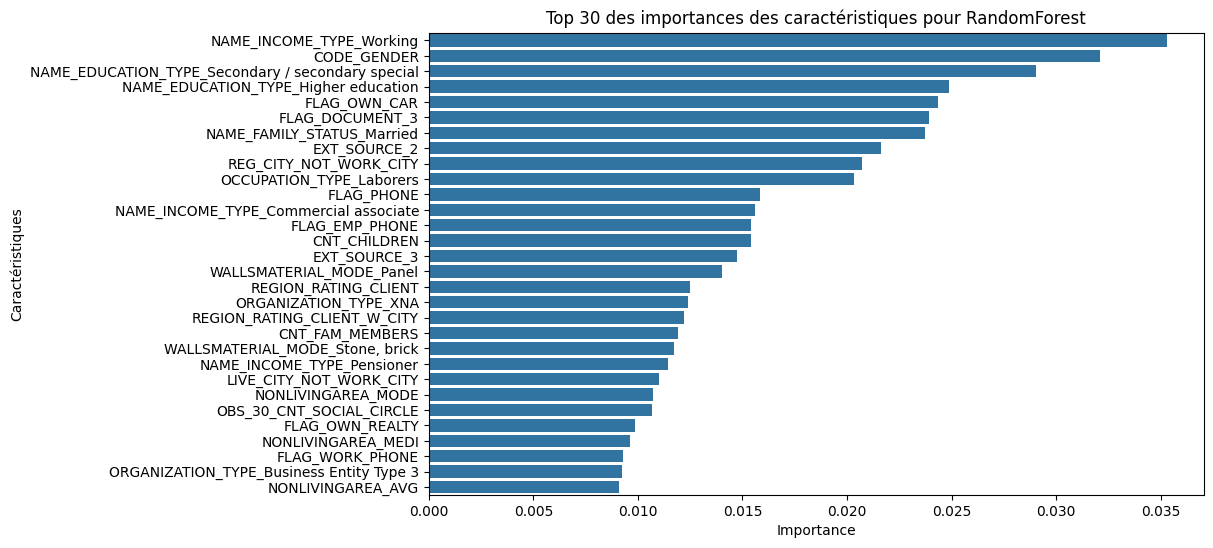

In [107]:
plot_feature_importances_rfc(feature_importances_df)

## MLflow

In [52]:

import mlflow
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib


def log_metrics_with_mlflow(pipeline, X_val, y_val, run_name="Model random forest Evaluation"):
    with mlflow.start_run(run_name=run_name):
        # Prédictions sur l'ensemble de validation
        y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
        y_pred = pipeline.predict(X_val)

        # Calculer la précision, le rappel, et l'AUC
        precision = precision_score(y_val, y_pred)
        rf_cout_metier = fonction_cout_metier_version_1(y_val, y_pred_proba)
        recall = recall_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred_proba)

        # Calculer et tracer la courbe ROC
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig("roc_curve.png")

        # Enregistrer les métriques dans MLflow
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric('Cout metier', rf_cout_metier)

        # Enregistrer la courbe ROC comme un artefact
        mlflow.log_artifact("roc_curve.png")

        # Enregistrer le modèle
        mlflow.sklearn.log_model(pipeline, "model")


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
c:\Users\naoue\Anaconda3\envs\third_env\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is

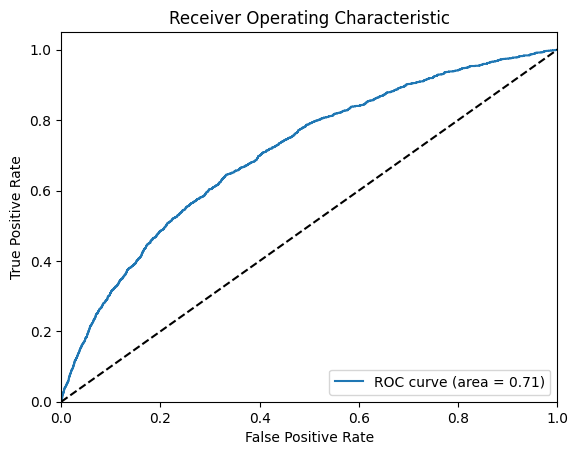

In [53]:
mlflow = log_metrics_with_mlflow(rdf_pipeline, X_val, y_val)

In [110]:
rf_model = rdf_pipeline.named_steps['randomforestclassifier']

In [111]:
rf_model

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200,
                       n_jobs=-1, verbose=1)

# Regression logistique 

### Rechereche de meilleures params

In [59]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline as imblearnPipeline
from imblearn.over_sampling import SMOTE

def logistic_regression_grid_search(df):
    if 'TARGET' not in df.columns:
        raise ValueError("La colonne 'TARGET' est absente du DataFrame.")

    # Définition des caractéristiques numériques et catégorielles
    numerical_feats = [f for f in df.columns if df[f].dtype in ['int64', 'float64'] and f not in ['TARGET']]
    categorical_feats = [f for f in df.columns if df[f].dtype == 'object']

    # Préprocesseur pour les caractéristiques numériques et catégorielles
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numerical_feats),
            ('cat', sklearnPipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
            ]), categorical_feats)
        ]
    )

    # Création du pipeline
    pipeline = imblearnPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('logisticregression', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Paramètres pour GridSearchCV
    param_grid = {
        'logisticregression__C': [0.01, 0.1, 1, 10]
    }

    # Division des données
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Configuration et exécution du GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=2)
    grid_search.fit(X_train, y_train)

    print("Meilleur score AUC: %s" % grid_search.best_score_)
    print("Meilleurs paramètres: %s" % grid_search.best_params_)

    return grid_search.best_estimator_


In [60]:
best_logistic_model = logistic_regression_grid_search(sampled_df)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................logisticregression__C=0.01; total time= 1.6min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................logisticregression__C=0.01; total time= 1.4min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................logisticregression__C=0.01; total time= 1.4min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................logisticregression__C=0.01; total time= 1.4min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .........................logisticregression__C=0.01; total time= 1.5min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..........................logisticregression__C=0.1; total time= 1.4min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..........................logisticregression__C=0.1; total time= 1.3min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..........................logisticregression__C=0.1; total time= 1.3min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..........................logisticregression__C=0.1; total time= 1.4min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..........................logisticregression__C=0.1; total time= 1.4min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................logisticregression__C=1; total time= 1.5min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................logisticregression__C=1; total time= 1.5min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................logisticregression__C=1; total time= 1.5min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................logisticregression__C=1; total time= 1.4min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............................logisticregression__C=1; total time= 1.3min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...........................logisticregression__C=10; total time= 1.3min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...........................logisticregression__C=10; total time= 1.3min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...........................logisticregression__C=10; total time= 1.4min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...........................logisticregression__C=10; total time= 1.4min


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...........................logisticregression__C=10; total time= 1.4min
Meilleur score AUC: 0.5810998681851223
Meilleurs paramètres: {'logisticregression__C': 1}


c:\Users\naoue\Documents\OpenClassroomDataScientist\projet_7_version_3\new_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
# Affichage des meilleurs paramètres
print("Meilleurs paramètres obtenus de GridSearchCV:")
print(best_logistic_model.get_params()['logisticregression__C'])


Meilleurs paramètres obtenus de GridSearchCV:
1


## Entrainer le meilleure modele 

In [56]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline as imblearnPipeline
from imblearn.over_sampling import SMOTE



def train_best_logistic_model(df):
    """
    Entraîne un modèle LogisticRegression avec un prétraitement spécifique,
    en utilisant les hyperparamètres ajustés.

    Parameters:
    df : DataFrame contenant les données d'entraînement et la cible.

    Returns:
    tuple: Contenant le pipeline entraîné, les ensembles de données d'entraînement et de validation,
           et le DataFrame des importances des caractéristiques.
    """
        
    if 'TARGET' not in df.columns:
        raise ValueError("La colonne 'TARGET' est absente du DataFrame.")

    # Définition des caractéristiques numériques et catégorielles
    numerical_feats = [f for f in df.columns if df[f].dtype in ['int64', 'float64'] and f not in ['TARGET']]
    categorical_feats = [f for f in df.columns if df[f].dtype == 'object']

    # Préprocesseur pour les caractéristiques numériques et catégorielles
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numerical_feats),
            ('cat', sklearnPipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
            ]), categorical_feats)
        ]
    )

    # Division en ensembles d'entraînement et de validation
    X = df.drop('TARGET', axis=1)
    y = df['TARGET']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Paramètres du modèle LogisticRegression
    lr_params = {
        'C': 1,
        'random_state': 42
    }
    
    # Création de la pipeline avec prétraitement, SMOTE, et LogisticRegression
    pipeline = imblearnPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('logisticregression', LogisticRegression(**lr_params))
    ])

    # Entraînement du modèle
    pipeline.fit(X_train, y_train)

    # Évaluation du modèle
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    y_pred = pipeline.predict(X_val)
    auc_score = roc_auc_score(y_val, y_pred_proba)
    accuracy = accuracy_score(y_val, y_pred)

    # Affichage des scores
    print(f"AUC: {auc_score}")
    print(f"Accuracy: {accuracy}")

    # La régression logistique n'a pas d'importance de caractéristique directement comparable à celle du random forest,
    # donc nous omettons cette partie pour la régression logistique

    return pipeline, X_train, X_val, y_train, y_val

In [57]:
logistic_regression_pipeline, X_train, X_val, y_train, y_val = train_best_logistic_model(sampled_df)


C:\Users\naoue\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.5316570307958763
Accuracy: 0.25321120806460357


### Mlflow

In [58]:

import mlflow
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib


def log_metrics_with_mlflow(pipeline, X_val, y_val, run_name="Model logistique regression Evaluation"):
    with mlflow.start_run(run_name=run_name):
        # Prédictions sur l'ensemble de validation
        y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
        y_pred = pipeline.predict(X_val)

        # Calculer la précision, le rappel, et l'AUC
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred_proba)
        lr_cout_metier = fonction_cout_metier_version_1(y_val, y_pred_proba)

        # Calculer et tracer la courbe ROC
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig("roc_curve.png")

        # Enregistrer les métriques dans MLflow
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("Cout metier",lr_cout_metier)

        # Enregistrer la courbe ROC comme un artefact
        mlflow.log_artifact("roc_curve.png")

        # Enregistrer le modèle
        mlflow.sklearn.log_model(pipeline, "model")


c:\Users\naoue\Anaconda3\envs\third_env\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\naoue\Anaconda3\envs\third_env\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


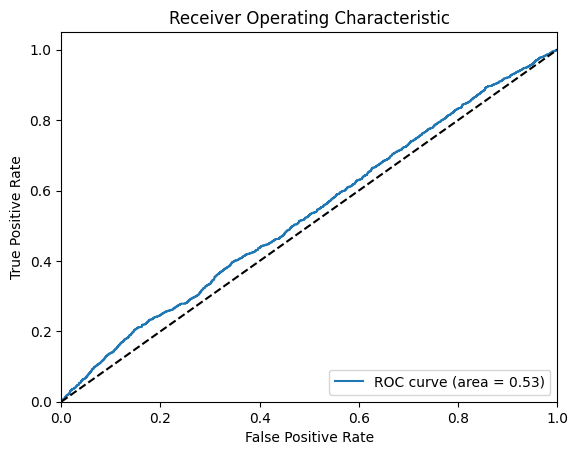

In [59]:
log_metrics_with_mlflow(logistic_regression_pipeline, X_val, y_val)